In [1]:
import os

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import optim
import pandas as pd
import numpy as np
from torchvision.utils import make_grid

In [3]:
torch.cuda.is_available()

True

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
dataset = 'camvid'
img_size = 256

In [7]:
X_TRAIN_DIR = f'{dataset}_data/train/'
Y_TRAIN_DIR = f'{dataset}_data/train_labels/'
X_VAL_DIR = f'{dataset}_data/val/'
Y_VAL_DIR = f'{dataset}_data/val_labels/'


X_train = [X_TRAIN_DIR+x for x in os.listdir(X_TRAIN_DIR) if x.endswith('.png')]# [::4]
y_train = [Y_TRAIN_DIR+x for x in os.listdir(Y_TRAIN_DIR) if x.endswith('.png')]# [::4]
X_val = [X_VAL_DIR+x for x in os.listdir(X_VAL_DIR) if x.endswith('.png')]# [::2]
y_val = [Y_VAL_DIR+x for x in os.listdir(Y_VAL_DIR) if x.endswith('.png')]# [::2]

print('TRAIN SAMPLES')
print(f'First 5 input samples\n{y_train[:5]}')
print(f'Length of Input Image: {len(y_train)}\n')
print(f'First 5 target samples\n{X_train[:5]}')
print(f'Length of Target Image: {len(X_train)}\n')

print('VALIDATION SAMPLES')
print(f'First 5 input samples\n{y_val[:5]}')
print(f'Length of Input Image: {len(y_val)}\n')
print(f'First 5 target samples\n{X_val[:5]}')
print(f'Length of Target Image: {len(X_val)}')

TRAIN SAMPLES
First 5 input samples
['camvid_data/train_labels/0001TP_006690_L.png', 'camvid_data/train_labels/0001TP_006720_L.png', 'camvid_data/train_labels/0001TP_006750_L.png', 'camvid_data/train_labels/0001TP_006780_L.png', 'camvid_data/train_labels/0001TP_006810_L.png']
Length of Input Image: 601

First 5 target samples
['camvid_data/train/0001TP_006690.png', 'camvid_data/train/0001TP_006720.png', 'camvid_data/train/0001TP_006750.png', 'camvid_data/train/0001TP_006780.png', 'camvid_data/train/0001TP_006810.png']
Length of Target Image: 601

VALIDATION SAMPLES
First 5 input samples
['camvid_data/val_labels/0001TP_009030_L.png', 'camvid_data/val_labels/0001TP_009060_L.png', 'camvid_data/val_labels/0001TP_009270_L.png', 'camvid_data/val_labels/0001TP_009300_L.png', 'camvid_data/val_labels/0001TP_009870_L.png']
Length of Input Image: 100

First 5 target samples
['camvid_data/val/0001TP_009030.png', 'camvid_data/val/0001TP_009060.png', 'camvid_data/val/0001TP_009270.png', 'camvid_data

In [8]:
class_map_df = pd.read_csv("camvid_data/class_dict.csv")
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
len(class_map), class_map[:5]

(32,
 [array([ 64, 128,  64]),
  array([192,   0, 128]),
  array([  0, 128, 192]),
  array([  0, 128,  64]),
  array([128,   0,   0])])

In [9]:
def assert_map_range(mask,class_map):
    mask = mask.astype("uint8")
    for j in range(img_size):
        for k in range(img_size):
            assert mask[j][k] in class_map , tuple(mask[j][k])

In [10]:
def form_2D_label(mask, class_map):
    mask = torch.tensor(mask, dtype=torch.uint8)
    label = torch.zeros(mask.shape[:2], dtype=torch.uint8)

    for i, rgb in enumerate(class_map):
        mask_rgb = torch.all(mask == torch.tensor(rgb), dim=2)
        label[mask_rgb] = i

    return label

In [11]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return torch.eye(num_classes, dtype='uint8')[y]

In [12]:
class CustomDataTrain(Dataset):
    def __init__(self, img, lab, class_map, transform):
        self.img = img
        self.lab = lab
        self.transform = transform
        self.class_map = class_map
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        img = self.img[idx]
        lab = self.lab[idx]

        img = Image.open(img).convert("RGB")
        lab = Image.open(lab).convert("RGB")
        
        img = self.transform(img)
        lab = self.transform(lab)
        
        lab = form_2D_label(lab, self.class_map)
        lab = to_categorical(lab, 32)

        return img, lab


In [13]:
batch_size = 32

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    
])

train_dataset = CustomDataTrain(X_train, y_train, class_map, transform=train_transform)
val_dataset = CustomDataTrain(X_val, y_val, class_map, transform=val_transform)

In [14]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size)

print(f'{len(train_dataloader)} batches of {len(train_dataset)} train data')
print(f'{len(val_dataloader)} batches of {len(val_dataset)} val data')

19 batches of 601 train data
4 batches of 100 val data


In [18]:
inp, tar = train_dataset[1]
inp, tar

RuntimeError: The size of tensor a (256) must match the size of tensor b (3) at non-singleton dimension 2

In [63]:
batch = next(iter(train_dataloader))
batch[0].shape

TypeError: Unexpected type <class 'numpy.ndarray'>

In [29]:
def show_batch(train_dataloader):
    batch = next(iter(train_dataloader))
    inp, tar = batch
    for i in range(3):
        idx = np.random.randint(0, len(inp)-1)
        plt.subplot(1, 2, 1)
        plt.imshow(inp[idx].permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(tar[idx].permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

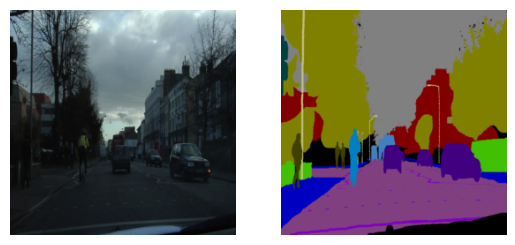

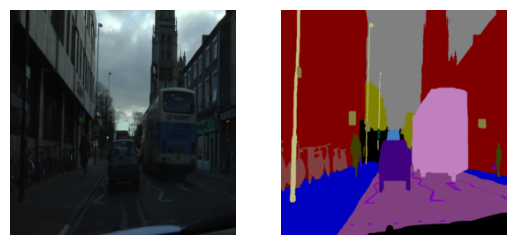

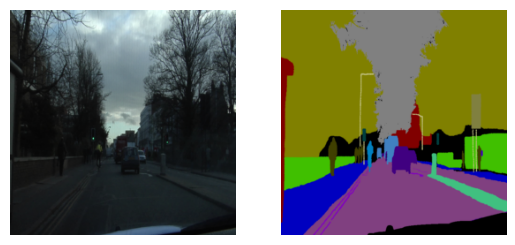

In [30]:
show_batch(train_dataloader)

In [ ]:
# custom weights initialization called on generator and discriminator        
def weights_init(net, init_type='normal', scaling=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>

In [ ]:
class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

In [ ]:
class Unet(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, nf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            nf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(Unet, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=None, innermost=True)  # add the innermost layer
        
        # add intermediate layers with ngf * 8 filters
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, use_dropout=use_dropout)
        
        # gradually reduce the number of filters from nf * 8 to nf
        unet_block = UnetSkipConnectionBlock(nf * 4, nf * 8, input_nc=None, submodule=unet_block)
        unet_block = UnetSkipConnectionBlock(nf * 2, nf * 4, input_nc=None, submodule=unet_block)
        unet_block = UnetSkipConnectionBlock(nf, nf * 2, input_nc=None, submodule=unet_block)
        self.model = UnetSkipConnectionBlock(output_nc, nf, input_nc=input_nc, submodule=unet_block, outermost=True)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = Unet(3, 3, 64, use_dropout=False).cuda()
model.apply(weights_init)

In [ ]:
lossfn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
def load_states_fn(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optim'])
    print(f"Epochs: {checkpoint['epoch']} | Train Loss: {checkpoint['train_loss'][-1]} | D_loss: {checkpoint['test_loss'][-1]}")
    return model, optimizer, checkpoint['train_loss'], checkpoint['test_loss']

In [ ]:
train_loss, test_loss = [], []

In [ ]:
model, optimizer, train_loss, test_loss = load_states_fn(model, optimizer, path=f'segmentation_checkpoint/{dataset}/model_camvid_epoch_200.pth')

In [ ]:
n_epochs = 30

for epoch in range(1, n_epochs+1):